In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
import nltk
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Gathering Data

In [3]:
base_csv = pd.read_csv('IMDB Dataset.csv')
base_csv

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Seperating Train and Test data

In [4]:
X, y = base_csv['review'].values, base_csv['sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify = y)
print(x_train.shape)
print(x_test.shape)

(37500,)
(12500,)


**Performing data analysis**

negative    18750
positive    18750
dtype: int64


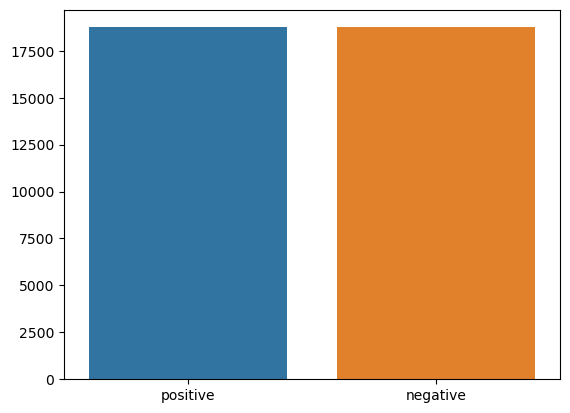

In [5]:
dd = pd.Series(y_train).value_counts()
print(dd)
sns.barplot(x = np.array(['positive', 'negative']), y = dd.values)
plt.show()

**Preprocess String**
Remove all characters except letters and digits
Remove extra white spaces
Remove digits

In [6]:
def preprocess_string(s):
    # remove all characters except letters and digits
    s = re.sub(r"[^\w\s]", '', s)
    #remove all extra whites spaces
    s = re.sub(r"\s+", '', s)
    #remove digits
    s = re.sub(r"\d", '', s)
    return s

**Tokenization**

Converts a sentence to its token vector and converts sentiment vector to its corresponding boolen vector

In [7]:
def create_word_list(x_train):
    word_list = []
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split(' '):
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
    return word_list
word_list = create_word_list(x_train)

In [8]:
def tokenize(x_train, y_train, x_test, y_test):
    corpus = Counter(word_list)
    corpus_ = sorted(corpus.items(), key = lambda x: x[1], reverse=True)[:1000]
    onehot_dict = {w[0]:i+1 for i, w in enumerate(corpus_)}
#     return onehot_dict
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_test:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_test] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict
    

In [9]:
def tockenize(x_train,y_train,x_val,y_val):
#     word_list = []

#     stop_words = set(stopwords.words('english')) 
#     for sent in x_train:
#         for word in sent.lower().split():
#             word = preprocess_string(word)
#             if word not in stop_words and word != '':
#                 word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    return onehot_dict
    # tockenize
#     final_list_train,final_list_test = [],[]
#     for sent in x_train:
#             final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
#                                      if preprocess_string(word) in onehot_dict.keys()])
#     for sent in x_val:
#             final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
#                                     if preprocess_string(word) in onehot_dict.keys()])
            
#     encoded_train = [1 if label =='positive' else 0 for label in y_train]  
#     encoded_test = [1 if label =='positive' else 0 for label in y_val] 
#     return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [10]:
x_train, y_train, x_test, y_test, vocab = tokenize(x_train, y_train, x_test, y_test)


C:\Users\rajwa\AppData\Local\Temp\ipykernel_10512\2573382031.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [11]:
x_train

array([list([11, 2, 221, 76, 22, 10, 59, 922, 101, 159, 773, 158, 1, 2, 608, 71, 179, 84, 651, 409, 62, 916, 54, 82, 101, 22, 76, 22, 118, 19, 4, 19, 662, 872, 163, 159, 246, 6, 370, 114, 314, 84, 630, 222, 266, 545, 269, 464, 5, 30, 792, 101, 315, 19, 266, 356, 411, 19, 70, 52, 5, 294, 11, 807, 29, 159, 22, 6, 821, 567, 31, 253, 364, 4, 356, 45, 1, 250, 125, 727, 51, 221, 2, 15, 11, 218, 112, 81, 38, 15, 11, 105, 19, 33, 62, 963, 14, 45, 224, 441, 531, 605, 22, 4, 341, 15, 11, 1, 185, 101, 348, 148, 30, 71, 380, 4, 59, 590, 133, 71, 429, 557, 879, 181, 13, 52, 617, 30, 183, 54, 748, 10, 13, 124, 173, 6, 796, 15, 2, 6, 805, 12, 4, 6, 57, 16, 14, 162, 2, 596, 195, 142, 183, 14, 59, 96, 14, 29, 356, 805, 467, 713, 404, 6, 697, 31, 269, 162, 12, 19, 478, 14, 200, 404, 81, 5, 58, 2, 317, 17, 12, 1, 46, 381, 118, 19, 22, 937, 71, 57, 153, 71, 409, 295, 524, 160, 129, 19, 295, 159, 31, 19, 5, 295, 101, 22, 159, 107, 101, 1, 19, 129, 557, 411, 401]),
       list([172, 314, 2, 850, 54, 208, 68

In [12]:
len(vocab)

1000

**Analysing our data**

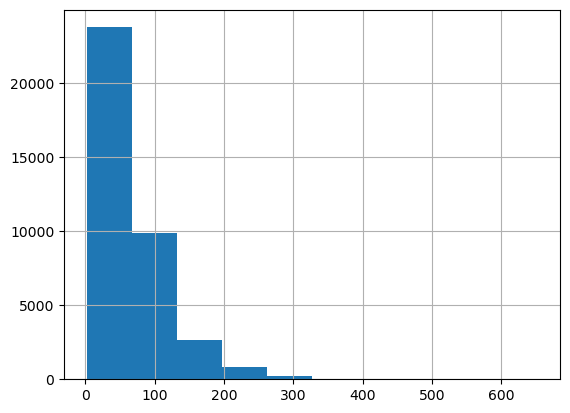

count    37500.000000
mean        69.280533
std         48.234108
min          2.000000
25%         39.000000
50%         54.000000
75%         85.000000
max        652.000000
dtype: float64

In [13]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

yeaaa!!

**Key Observations from EDA**

* Mean length of words in reviews is around 69
* Minimum length is 2
* Some reviews are quite large and approx 75 % of data has less than 84 reviews. These too large reviews can be studied manually or seperately

**Padding**

Now, we will padd the reviews to a max length so that each review has equal length

In [14]:
def padding(sents, seq_len):
    features = np.zeros((len(sents), seq_len), dtype = int)
    for i, rev in enumerate(sents):
        if len(rev) != 0:
            features[i, -len(rev):] = np.array(rev)[:seq_len]
    return features

In [15]:
# we have very less number of reviews of length > 500, so we will take review uptill length 500 only
x_train_pad = padding(x_train, 500)
x_test_pad = padding(x_test, 500)

**Loading Data as Tensors**

In [16]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# batch size
batch_size = 50

# shuffle data

train_loader = DataLoader(train_data, shuffle=True, batch_size = batch_size)
test_loader = DataLoader(test_data, shuffle= True, batch_size = batch_size)

In [17]:
for i, batch in enumerate(train_loader):
#     print(len(batch))
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[0])
    print(batch[1])

    break

torch.Size([50, 500])
torch.Size([50])
tensor([[  0,   0,   0,  ..., 189, 717, 766],
        [  0,   0,   0,  ...,  58, 757,   2],
        [  0,   0,   0,  ...,  74,  22,   8],
        ...,
        [  0,   0,   0,  ...,  25,  14, 970],
        [  0,   0,   0,  ..., 167, 866, 504],
        [  0,   0,   0,  ...,  40,   3,  23]], dtype=torch.int32)
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 1], dtype=torch.int32)


In [18]:
#obtain one batch
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print(f"Size of Batch {sample_x.size()}")
print(f"Sample input {sample_x}")
print(f"Sample output {sample_y}")
# obtain one batch of training data


Size of Batch torch.Size([50, 500])
Sample input tensor([[  0,   0,   0,  ..., 750, 134, 917],
        [  0,   0,   0,  ...,  30,   3, 307],
        [  0,   0,   0,  ...,   1, 139, 278],
        ...,
        [  0,   0,   0,  ..., 477, 407, 804],
        [  0,   0,   0,  ...,  16, 204, 371],
        [  0,   0,   0,  ...,   7, 235, 605]], dtype=torch.int32)
Sample output tensor([1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 0], dtype=torch.int32)


**We need to add an embedding layer because there are more words in out vocab and it is in-efficient to one_hot_encode that many words. So we will just find out word embedding using word2vec embedding layer and use that as lookup table, but we also just add extra layer, using it only for embeddings and let the network learn the weights itself**

In [19]:
class SentimentLSTM(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob = 0.5):
        super(SentimentLSTM, self).__init__()
        
        self.no_layers = no_layers
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  
        
        #LSTM
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = self.hidden_dim, num_layers = no_layers, batch_first=True)
        
        #dropout layers
        self.dropout = nn.Dropout(0.3)
        
        #linear and Sigmoid layer
        
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self, x, hidden):
        # we just passed a batch
        batch_size = x.size(0) # batch size -> B
        #embed shape -> [B, max_len, embed_dim]
        embeds = self.embedding(x)
        
        
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        
        # drop out and fully connected
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid 
        
        sig_out = self.sig(out)
        
        #reshape to batch size first
        
        sig_out = sig_out.view(batch_size, -1)
        
        sig_out = sig_out[:, -1]
        
        
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        
        # create hidden state and cell state tensors with size [no_layers x batch_size x hidden_dim]
        
        hidden_state = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        cell_state = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (hidden_state, cell_state)
        return hidden

In [20]:
no_layers = 2 # no of layers in lstm
vocab_size = len(vocab) + 1 # extra for 0 (padding symbol)
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = SentimentLSTM(no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob = 0.5)
# move operations on GPU
model.to(device)
model

SentimentLSTM(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

Now, model is ready. **Traning Phase**

In [21]:
# loss and optimization features

lr = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# accuracy function
def accuracy(pred, label):
    pred =torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

**Training**

In [23]:
clip = 5
epochs = 5
test_loss_min = np.Inf
epoch_tr_loss, epoch_tst_loss = [], []
epoch_tr_acc, epoch_tst_acc = [], []

for epoch in range(epochs):
    train_loss = []
    train_acc = 0
    h = model.init_hidden(batch_size)
    model.train()
    # processing each batch
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        h = tuple([each.data for each in h])
        model.zero_grad()
        output, h = model(x, h)
        
        #calculate loss
        
        loss = criterion(output.squeeze(), y.float())
        loss.backward()
        train_loss.append(loss.item())
        
        #acuracy
        
        acc = accuracy(output, y)
        
        train_acc += acc
        #clip_Grad_norm clips the grad or simply prevents exploding of gradient
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    test_h = model.init_hidden(batch_size)
    test_loss = []
    test_acc = 0
    model.eval()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        test_h = tuple([each.data for each in test_h])
        
        output, test_h = model(x, test_h)
        
        loss = criterion(output.squeeze(), y.float())
        test_loss.append(loss.item())
        
        acc = accuracy(output, y)
        
        test_acc += acc
        
    epoch_train_loss = np.mean(train_loss) # take average loss for each batch
    epoch_test_loss = np.mean(test_loss)
    
    epoch_tr_loss.append(epoch_train_loss)
    epoch_tst_loss.append(epoch_test_loss)
    
    epoch_train_acc = train_acc / len(train_loader.dataset)
    
    epoch_test_acc = test_acc / len(test_loader.dataset)
    
    epoch_tr_acc.append(epoch_train_acc)
    epoch_tst_acc.append(epoch_test_acc)
    
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} test_loss : {epoch_test_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} test_accuracy : {epoch_test_acc*100}')
    if epoch_test_loss <= test_loss_min:
        torch.save(model.state_dict(), 'working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(test_loss_min,epoch_test_loss))
        test_loss_min = epoch_test_loss
    print(25*'==')
        
        
        
    
        

Epoch 1
train_loss : 0.4229308822751045 test_loss : 0.3556612042784691
train_accuracy : 80.97866666666667 test_accuracy : 84.72800000000001
Validation loss decreased (inf --> 0.355661).  Saving model ...
Epoch 2
train_loss : 0.32792574940125147 test_loss : 0.3357208213806152
train_accuracy : 85.88 test_accuracy : 85.72800000000001
Validation loss decreased (0.355661 --> 0.335721).  Saving model ...
Epoch 3
train_loss : 0.3010317895412445 test_loss : 0.32785353443026544
train_accuracy : 87.152 test_accuracy : 86.11999999999999
Validation loss decreased (0.335721 --> 0.327854).  Saving model ...
Epoch 4
train_loss : 0.2792201054592927 test_loss : 0.33133913254737857
train_accuracy : 88.18933333333334 test_accuracy : 85.64
Epoch 5
train_loss : 0.2519594584802787 test_loss : 0.3299460093677044
train_accuracy : 89.45066666666666 test_accuracy : 85.88799999999999


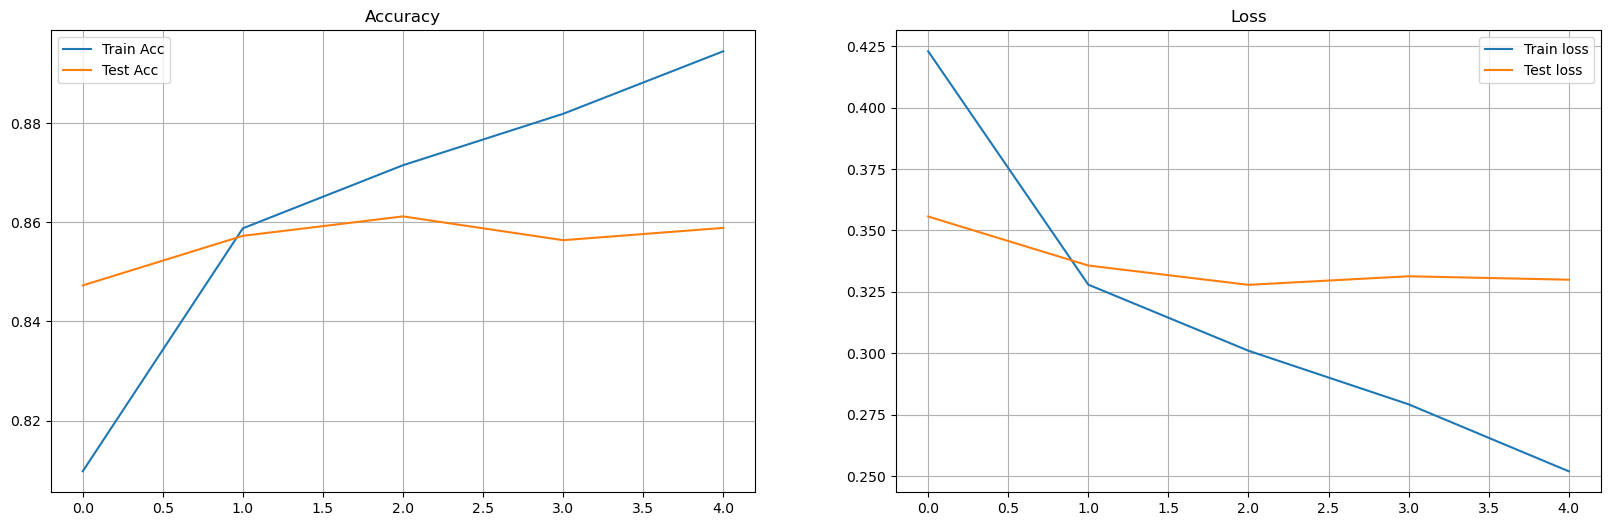

In [24]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_tst_acc, label='Test Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_tst_loss, label='Test loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [25]:
def predict_sentiment(text):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq, axis = 0)
    print(word_seq)
    pad = torch.from_numpy(padding(word_seq, 500))
    
    inputs = pad.to(device)
    batch_size = 1
    h = model.init_hidden(batch_size)
    output, h = model(inputs, h)
    return output.item()

In [26]:
index = 30
review, sentiment = base_csv['review'][index], base_csv['sentiment'][index]
print("The statement is:")
print(review)
print("=="*25)
print(f"Original Sentiment is: {sentiment}")
print("=="*25)
pred = predict_sentiment(review)
status = "positive" if pred > 0.5 else "negative"
print(f"Predicted Sentiment is {status} with probability of {pred}.")

The statement is:
Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance